In [81]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

class Point:
    def __init__(self,x,y):
        self.x = x
        self.y = y

class Rectangle:
    def __init__(self,x,y,w,h):
        # x,y = center of the Rectangle
        # w = edge to edge horizontal distance
        # h = edge to edge vertical distance
        self.x = x
        self.y = y
        self.w = w
        self.h = h
        self.west_edge, self.east_edge = x - w/2, x + w/2
        self.north_edge, self.south_edge = y-h/2, y+h/2

    def contains(self,point):
        return (point.x >= self.west_edge and point.x <= self.east_edge and
        point.y >= self.north_edge and point.y <= self.south_edge)

    def show(self, axis):
        #axis.add_patch(patches.Rectangle((self.x-self.w,self.y-self.h),self.w*2,self.h*2,fill=False))
        x1, y1 = self.west_edge,self.north_edge
        x2, y2 = self.east_edge, self.south_edge
        # axis.plot([x1,x2,x2,x1,x1],[y1,y1,y2,y2,y1], c='black', lw=1)
        axis.add_patch(patches.Rectangle((self.west_edge,self.south_edge),
        (self.east_edge-self.west_edge),
        (self.north_edge-self.south_edge),fill=False))
class Quadtree:
    def __init__(self,boundary,n = 4):

        self.boundary = boundary

        # choosing capacity(n) = 4, i.e. if particle number crosses 4 than sub-divide
        # When do i choose that i need to sub-divide
        self.capacity = n

        # Keep track of points:
        self.points = []

        self.divided = False

    def subdivide(self):

        x = self.boundary.x
        y = self.boundary.y
        w = self.boundary.w/2
        h = self.boundary.h/2

        ne = Rectangle(x + w/2,y - h/2, w,h)
        self.northeast = Quadtree(ne,self.capacity);
        nw = Rectangle(x - w/2,y - h/2, w,h)
        self.northwest = Quadtree(nw,self.capacity);
        se = Rectangle(x + w/2,y + h/2, w,h)
        self.southeast = Quadtree(se,self.capacity);
        sw = Rectangle(x - w/2,y + h/2, w,h)
        self.southwest = Quadtree(sw,self.capacity);

        self.divided = True

    def insert(self,point):

        # If the point isn't in the boundary then stop!
        if self.boundary.contains(point) != True:
            return False

        # Check if the number of points exceed the capacity
        if len(self.points) < self.capacity:
            # if the point does not exceed then add the point,
            # to the list of points in the boundary
            self.points.append(point)
            return True
        # If the number of points exceed the given capacity then
        # subdivide the rectangular boundary into four parts

        # subdivide boundary
        if not self.divided:
            print('divided')
            self.subdivide()

        return (self.northeast.insert(point) or
        self.northwest.insert(point) or
        self.southeast.insert(point) or
        self.southwest.insert(point))

    def show(self,axis):
        self.boundary.show(axis)
        if self.divided:
            self.northeast.show(axis)
            self.northwest.show(axis)
            self.southeast.show(axis)
            self.southwest.show(axis)


divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided
divided


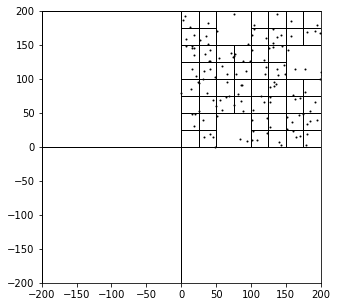

In [82]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle as rect
import utils
fig, ax = plt.subplots(figsize=(5,5))

# specs of Rectangle:
width = 400
height = 400
center_x = 0
center_y = 0
boundary = utils.Rectangle(center_x,center_y,width,height)
qt = utils.Quadtree(boundary, 4)

for i in range(550):
    x = np.random.randint(0,400)
    y = np.random.randint(0,400)

    p = utils.Point(x,y)
    ax.scatter(p.x,p.y,s=1,c='black')
    qt.insert(p)
ax.set_xlim(center_x-width/2,center_x+width/2)
ax.set_ylim(center_y-height/2,center_y+height/2)

qt.show(ax)
plt.show()
